# Simulating p-values in the frequentist and bayesian paradigms

In this notebook, we'll conduct a handful of experiments related to p-values in the frequentist (hypothesis testing) framework as well as in the bayesian (model-checking) framework. Goal of the simulations include elaborating on the following:

* To what extent can we trust p-values?
* How often do we erroneously obtain a rejection of the null hypothesis (a "type 1 error" or a "false positive")?
* How does the frequentist p-value paradigm fail in the scenario of multiple testing?
* How do bayesians use (posterior) p-values for model-checking?

...And more.

In [1]:
# first, some imports:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels as sm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm

- - - - -
# Simulating the null hypothesis significance testing framework.

We wish to demonstrate the following:
* $p$-values are uniformly distributed when the null hypothesis is true (and all of the test assumptions hold); and
* that the distribution is no longer uniform when the above fails.

We'll base our example around a double-sided t-test; in particular, our population will be infinite and represented by a Normal distribution with variance $\sigma^2 = 10$ and mean $\mu = 0$, both of which we pretend not to know. Our hypotheses are as follow:
* $H_\emptyset$: the population mean is zero ($\mu = 0$).
* $H_A$: the population mean is nonzero ($\mu \neq 0$).
The resulting test statistic is then given by
$$
t = \frac{\hat{\mu} - 0}{\hat{\sigma} / \sqrt(n)}
$$
where:
* $\hat{\mu}$ is our sample-based estimate of the population mean;
* $\hat{\sigma}$ is our sample-based estimate of the population standard deviation;
* $n$ is the number of elements in our sample;
* and $t$ is the $t$-statistic, whose distribution (in our case) is the Student-t distribution with $(n-1)$ degrees of freedom and 

In [2]:
# Define global constants specifying the population parameters:
# ...In "real life", these parameters would be unknown and answering questions about them
# is the point of statistical hypothesis testing.
POP_MEAN = 0.
POP_VARIANCE = 10.

In [3]:
# Function to generate a random sample from the population:
def get_sample(size):
    return np.random.normal(loc=POP_MEAN, scale=np.sqrt(POP_VARIANCE), size=size)

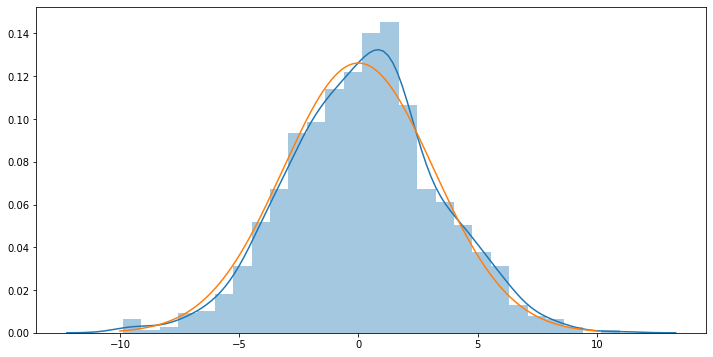

In [4]:
# Verify that we have a sample from a normal distribution (run this cell multiple times until convinced):
plt.figure(figsize=(12,6))
sns.distplot(get_sample(size=1000))
_xs = np.linspace(-10.,10.,num=1000)
plt.plot(_xs, stats.distributions.norm.pdf(_xs, loc=POP_MEAN, scale=np.sqrt(POP_VARIANCE)))

In [5]:
# Function to compute the t-statistic of a sample:
def t_statistic(sample):
    return (np.mean(sample) / (np.std(sample) / np.sqrt(sample.shape[0])))

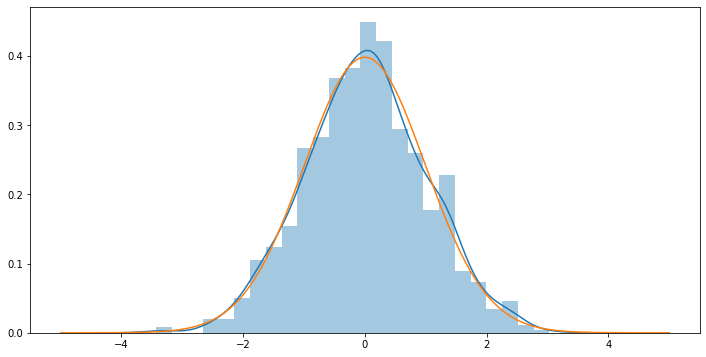

In [6]:
# Verify that we have a t-distribution with df = 99 (run this cell multiple times until convinced):
_tstats99 = [ ]
for k in range(1000):
    _tstats99.append( t_statistic(get_sample(100)) )
plt.figure(figsize=(12,6))
sns.distplot(_tstats99)
_xs = np.linspace(-5., 5., num=1000)
plt.plot(_xs, stats.distributions.t.pdf(_xs, df=99))

In [7]:
# Function to generate a p-value from the t-statistic for a given sample:
def pvalue(sample):
    # compute the t-statistic
    t = t_statistic(sample)
    # compute the integral from t to INFTY or from t to -INFTY:
    df = sample.shape[0]-1
    if t > 0:
        pval = stats.t.sf(t, df) # sf = (1 - cdf)
    else:
        pval = stats.t.cdf(t, df)
    return pval

In [8]:
pvalue(get_sample(100))

0.273423292378857

- - -
With our hypothesis-testing functions in hand, let's first plot the distribution of p-values with respect to randomly-generated samples under the assumption that the null hypothesis is true. We can visually confirm that the p-value distribution is in fact uniformly distributed.

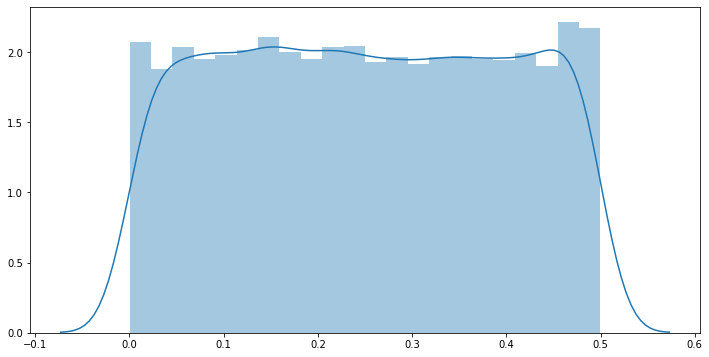

In [9]:
# plot the distribution of p-values with respect to randomly-generated samples:
# (We can confirm that p-values are in fact uniformly distributed if the null hyp is true.)
plt.figure(figsize=(12,6))
_pvals = [ ]
for _ in range(10000):
    _pvals.append( pvalue(get_sample(100)) )
sns.distplot(_pvals)

 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

* Kurtosis = -1.140121424077413 for pval dist with sample means = +0.25


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

* Kurtosis = 0.8414760520195985 for pval dist with sample means = +0.5


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

* Kurtosis = 8.559498520455355 for pval dist with sample means = +0.75


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

* Kurtosis = 53.46836525596685 for pval dist with sample means = +1.0


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]

* Kurtosis = 319.3251033335678 for pval dist with sample means = +1.25


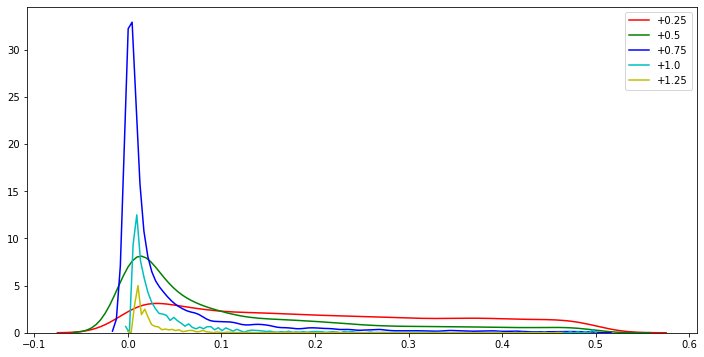

In [10]:
# Now let's show how the p-value distribution evolves as we slowly move away from the null hypothesis,
# by varying the mean of our sample away from the population mean:
_alt_hyp_pvals = {'+0.25': [], '+0.5': [], '+0.75': [], '+1.0': [], '+1.25': []}
colors = [ 'r', 'g', 'b', 'c', 'y' ]
plt.figure(figsize=(12,6))
for k,key in enumerate(tqdm(['+0.25', '+0.5', '+0.75', '+1.0', '+1.25'])):
    sample_mean = POP_MEAN + (k+1)*0.25
    for _ in range(10000):
        shifted_sample = sample_mean + get_sample(100)
        _alt_hyp_pvals[key].append( pvalue(shifted_sample) )
    sns.distplot(_alt_hyp_pvals[key], color=colors[k], label=key, hist=False, kde=True)
    print("* Kurtosis = {} for pval dist with sample means = {}".format(stats.kurtosis(_alt_hyp_pvals[key]), key))

We can notice in the above plot that the p-value distribution gets 'peakier' the more we break our assumptions; and this process happens very quickly, with the kurtosis increasing exponentially as we incrementally deviate the sample mean away from the true population mean by 0.25.

(Note that kurtosis is actually a measure of _tailedness_ rather than 'peakedness', but the uniform distribution is highly platykurtotic, hence the use of the increasing leptokurtoticity of the p-value distributions as an indicator of deviation from uniformity.)
- - - 
Now, let's see what happens to our p-value distribution when we break the assumptions on the sampling distribution.

We'll compare the p-value distribution from a normal distribution to those of a gamma distribution.

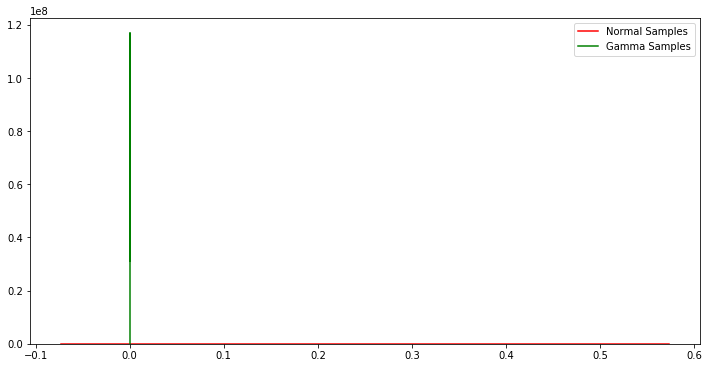

In [11]:
_normal_pvals = []
_gamma_pvals = []

plt.figure(figsize=(12,6))
# run experiment 10,000 times for normal:
for _ in range(10000):
    # compute p-value of t-statistic for normal-dist samples:
    _normal_pvals.append( pvalue(get_sample(100)) )
    # compute p-value of t-statistic for gamma samples:
    _gamma_pvals.append( pvalue(stats.gamma.rvs(1., scale=10., size=100)) )
sns.distplot(_normal_pvals, color='r', label='Normal Samples', kde=True, hist=False)
sns.distplot(_gamma_pvals, color='g', label='Gamma Samples', kde=True, hist=False)
plt.legend(loc='best')

Clearly the p-value distribution is sensitive to the validity of the testing assumptions.

- - - - - - - - - -
# Multiple hypothesis testing correction procedures: Bonferroni & Benjamini-Hochberg.

We've already demonstrated above that for a given chosen significance level, e.g. $\alpha = 0.05$, there is a 5% chance that we reject the null hypothesis even if it is true (i.e. a type I error, also known as a _false positive_ or _false discovery_ ). This is obvious given that the p-value distribution is uniformly distributed when the null hypothesis is true and all testing assumptions are valid.

We now demonstrate the flaws in repeating a large number of statistical tests; in particular, we will show that the probability of a false discovery increases with the number of tests. This can be a major flaw when applying large-scale automated statistical testing and may have grave consequences (e.g. in healthcare).

We will also show the results when we apply the Bonferroni and the Benjamini-Hochberg corrections, the two most popular correction procedures that fix the multiple testing problem.

Our demonstration of the pitfalls of multiple testing is based on the following (possibly contrived) anecdote: suppose we had measurements $y_{i,j}$ for $i=1,\ldots,10$ representing ten genes with $j=1,\ldots,J$ datapoints from each gene. The data is normally distributed:

$$
y_{i,j} \sim \mathcal{N}(\mu_i,\sigma_i^2),
$$

where $\mu_i$ and $\sigma_i$ are unknown for each $i$ --- although since this is a contrived example, we have "behind the scenes" knowledge that each $\mu_i$ is zero and we fix the values of the $\sigma_i$'s to be in the range $[1,5]$. Suppose, as before, we want to test whether $\mu_i = 0$ for each $i$; our null hypothesis is $\mu_i = 0$ with significance $\alpha = 0.1$.

This gives us the following test statistic:

$$
t_i = \frac{\sum_j y_{i,j}}{\mbox{s.d.}(y_i) / \sqrt{J}}
$$

and the distribution of each $t_i$ under the null is the student's t-distribution with $df = J-1$.

- - -
First, let's write a Monte Carlo simulation scheme to perform ten tests simultaneously and return a vector of ten p-values:

In [12]:
MHT_STDDEVS = [ 1.0, 2.0, 3.0, 4.0, 5.0, 5.0, 4.0, 3.0, 2.0, 1.0 ]
MHT_MEANS = [ 0.0 for _ in range(10) ]

def multiple_tests(means=MHT_MEANS, stdvs=MHT_STDDEVS, sample_size=30):
    """
    Run ten simultaneous tests on a dataset generated by the model above.
    """
    pvals = []
    for i in range(10):
        # generate data:
        yi = stats.norm.rvs(loc=means[i], scale=stdvs[i], size=sample_size)
        # compute test statistic:
        tstat = np.mean(yi) / (np.std(yi) / np.sqrt(sample_size))
        # compute p-value:
        df = sample_size-1
        pv = stats.t.sf(tstat, df) if (tstat > 0.0) else stats.t.cdf(tstat, df)
        pvals.append(pv)
    return np.array(pvals)

In [13]:
# test out our function:
multiple_tests() < 0.1

array([False, False, False,  True, False, False,  True, False, False,
       False])

And now let's write the function that runs the multiple testing scenario repeatedly and count the number of false positives.

In [14]:
def multiple_testing_monte_carlo(per_test_sig=0.1, nsims=100):
    """
    Run `ntests` tests in parallel at a per-test alpha of `per_test_sig` and
    report the the number of false positives.
    """
    ctr = 0
    for k in range(nsims):
        ctr += np.sum(multiple_tests() < per_test_sig)
    return ctr

In [15]:
print("Number of false positives: {}".format(multiple_testing_monte_carlo(per_test_sig=0.1, nsims=100)))

Number of false positives: 211


- - -
The _Bonferroni correction procedure_ focuses on minimizing the _family-wise error rate_ (FWER), which is the probability of making at least one type I error in $M$ hypothesis tests:

$$
\mbox{FWER} := \mathbf{P}(\# \mbox{ (wrongly reject null hyp) } \geq 1).
$$

Given an array of p-values from $M$ tests, the Bonferroni procedure is very easy to implement: just divide your per-test significance level by the number of tests performed; hence if each individual test was performed with a significance level of $\alpha = 0.05$, to get a FWER of 0.05 on $M$ tests, throw away any p-value greater than $\alpha / M = 0.05 / M$.

In [16]:
def bonferroni(pvals, fwer=0.05):
    """
    Args:
    * pvals: NDArray of float type & shape (NTESTS,); the p-values from our tests.
    * fwer: float; family-wise error rate
    
    Returns:
    * correct: NDArray of bool type and shape (NTESTS,); entry k is True if and only
    if pvals[k] passes the correction procedure.
    """
    return (pvals < fwer/pvals.shape[0])

Now let's see it in action:

In [17]:
def multiple_testing_monte_carlo_bonferroni(per_test_sig=0.1, nsims=100):
    """
    Run `ntests` tests in parallel at a per-test alpha of `per_test_sig`.
    Perform bonferroni correction in the last step of each simulation.
    """
    ctr = 0
    for k in range(nsims):
        ctr += np.sum(multiple_tests() < per_test_sig / 10.0) # divide alpha by M=10 tests
    return ctr

In [18]:
multiple_testing_monte_carlo(per_test_sig=0.1, nsims=100)

229

In [19]:
multiple_testing_monte_carlo_bonferroni(per_test_sig=0.1, nsims=100)

20

In [20]:
# plot the distribution of false positives:
mht_bonferroni_fps = []
mht_original_fps = []
for k in trange(100):
    mht_original_fps.append(multiple_testing_monte_carlo(per_test_sig=0.1, nsims=100))
    mht_bonferroni_fps.append(multiple_testing_monte_carlo_bonferroni(per_test_sig=0.1, nsims=100))

100%|██████████| 100/100 [00:54<00:00,  1.88it/s]


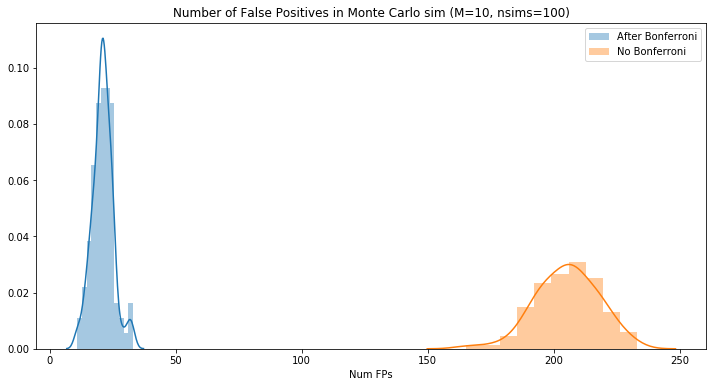

In [21]:
plt.figure(figsize=(12,6))
sns.distplot(mht_bonferroni_fps, label="After Bonferroni")
sns.distplot(mht_original_fps, label="No Bonferroni")
plt.title("Number of False Positives in Monte Carlo sim (M=10, nsims=100)")
plt.legend(loc='best')
_ = plt.xlabel("Num FPs")

- - -
In comparison, the Benjamini-Hochberg procedure focuses on controlling the _false discovery rate_ (FDR):

$$
\mbox{FDR} := \mathbf{E}[ \#\mbox{(wrongly reject null hyp) } / \# \mbox{(reject null hyp) } ]
$$

...where the ratio inside the expectation is defined to be zero when the denominator is zero.

The Benjamini-Hochberg procedure is less straightforward, but can still be implemented in a few lines of code.
The procedure works as follows: for a set of p-values $\vec{p} = (p_1, \ldots, p_M)$ and their order statistics $o(\vec{p},1), \ldots, o(\vec{p}, M)$ from smallest p-value to largest p-value, compute the Benjamini-Hochberg critical values

$$
BH[o(\vec{p},i)] = \mbox{FDR} * i / M
$$

for each index $i$ and for a chosen FDR representing the largest false discovery rate that you are willing to tolerate. Then, find the largest p-value $\hat{p}$ that is smaller than its critical value and mark every p-value smaller than or equal to $\hat{p}$ as significant.

The BH procedure works best when the $M$ different hypothesis tests are statistically independent. When the tests are _not_ independent, the Benjamini-Yekutieli procedure can be used, which is a slight modification of the Benjamini-Hochberg procedure.

In [22]:
def benjamini_hochberg(pvals, fdr=0.1):
    """    
    Args:
    * pvals: NDArray of float type & shape (NTESTS,); the p-values from our tests.
    * fdr: float; the acceptable false discovery rate.
    
    Returns:
    * correct: NDArray of bool type and shape (NTESTS,); entry k is True if and only
    if pvals[k] passes the correction procedure.
    """
    # compute B-H critical values:
    pvals_crit = np.stack([
        pvals,
        (np.argsort(pvals)+1) * fdr/pvals.shape[0],
    ], axis=1)
    # compute largest p-value that doesn't exceed its critical value:
    if len(pvals_crit[pvals_crit[:,0] < pvals_crit[:,1], 0]) == 0:
        return np.array([])
    else:
        max_crit_pval = np.amax(pvals_crit[pvals_crit[:,0] < pvals_crit[:,1], 0])
    # mark all p-values lower than the largest sub-critical p-value as significant and return:
    return pvals[pvals < max_crit_pval]

In [23]:
# test benjamini-hochberg function:
benjamini_hochberg(multiple_tests(), fdr=0.25)

array([], dtype=float64)

In [24]:
def multiple_testing_monte_carlo_benjamini(per_test_sig=0.1, nsims=100):
    """
    Run `ntests` tests in parallel at a per-test alpha of `per_test_sig`.
    Perform benjamini-hochberg correction in the last step of each simulation.
    """
    ctr = 0
    for k in range(nsims):
        ctr += np.sum(benjamini_hochberg(multiple_tests(), fdr=0.1) < per_test_sig) # apply BH
    return ctr

In [25]:
mht_benjamini_fps = []
for k in trange(100):
    mht_benjamini_fps.append(multiple_testing_monte_carlo_benjamini(per_test_sig=0.1, nsims=100))

100%|██████████| 100/100 [00:29<00:00,  3.64it/s]


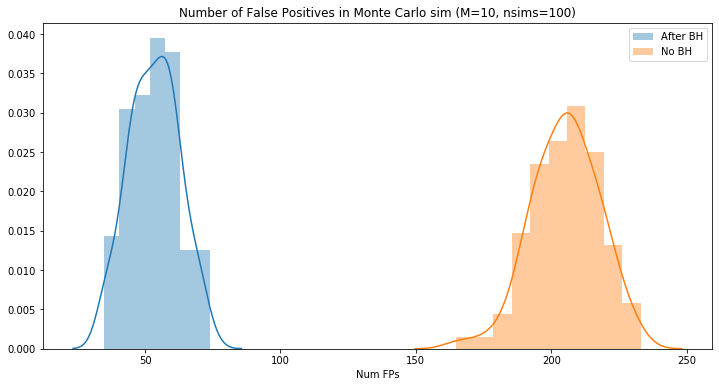

In [26]:
plt.figure(figsize=(12,6))
sns.distplot(mht_benjamini_fps, label="After BH")
sns.distplot(mht_original_fps, label="No BH")
plt.title("Number of False Positives in Monte Carlo sim (M=10, nsims=100)")
plt.legend(loc='best')
_ = plt.xlabel("Num FPs")